In [68]:
import sys
import os

import pandas as pd
import numpy as np
import natsort
import random as rn
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import pyeeg
from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps

import matplotlib.pyplot as plt

#Keras

#Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from sklearn.svm import (SVC, SVR)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
seed=42
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)
dir_path = os.getcwd()

# https://en.wikipedia.org/wiki/Neural_oscillation
SAMPLE_PER_SEC = 128
ALPHA_WAVE = [7.5, 12.5]
BETA_WAVE = [13, 30]
THETA_WAVE = [4, 8]
DELTA_WAVE = [1, 4]
LOW_GAMMA_WAVE = [30, 70]
HIGH_GAMMA_WAVE = [70, 150]



In [88]:
def get_train_from_csv(csv_file):
    '''
    get a numpy array y of labels. the order follows the id of 4 second sample. 
    argument: relative path to the csv_file from the source folder.
    '''
    csv_file = os.path.join(dir_path, csv_file)
    print(f"Reading {csv_file}")
    with open(csv_file, 'r') as csvfile:
        train_reader = pd.read_csv(csvfile)
        train_reader.drop(labels="Id", axis=1, inplace=True)
        
        
    return train_reader.values

def get_target_from_csv(csv_file):
    '''
    get a numpy array y of labels. the order follows the id of 4 second sample. 
    argument: relative path to the csv_file from the source folder.
    '''
    csv_file = os.path.join(dir_path,csv_file)
    with open(csv_file, 'r') as csvfile:
        label_reader = pd.read_csv(csvfile)
        #print("Labels: ", label_reader['id'])
        y = label_reader['y']
        
    y = np.array(y)
    return y

def get_features_emg_wavelet(X):
    """
     absolute EEG power in the 1–4Hz
    (delta), 5–9Hz (theta), 10–20Hz (low beta), and 30–40Hz (high beta) bands, absolute EMG
    power in the 1–10Hz band, theta-to-delta ratio, and beta-to-delta ratio 
    """
    all_featues = []
    for i in tqdm(range(X.shape[0])):
        features = list()
        x_i = X[i,:]
        delta = bandpower(x_i, DELTA_WAVE)
        features.append(delta)
        
        theta = bandpower(x_i, THETA_WAVE)
        features.append(theta)
        
        beta = bandpower(x_i, BETA_WAVE)
        features.append(beta)
        
        features.append(bandpower(x_i, ALPHA_WAVE))
        
        features.append(theta / delta)
        features.append(beta / delta)
    
        all_featues.append(features)
    return np.array(all_featues)

def get_features_emg(X):
    all_featues = []
    for i in tqdm(range(X.shape[0])):
        features = list()
        # https://ieeexplore.ieee.org/document/7748960
        x_i = X[i,:]
        # Root Mean Square (RMS): RMS of EMG
        features.append(mean_squared_error(x_i, np.zeros(x_i.shape)))
        
        #Integrated Absolute Value (IAV)
        features.append(np.sum(np.abs(x_i)))
        
        # Mean Absolute Value (MAV): MAV feature can be expressed as
        features.append(np.mean(x_i))
        
        # TBD:
        # Modified Mean Absolute Value type 1
        # Modified Mean Absolute Value type 2
        
        # Simple Square Integral (SSI): SSI is calculated as
        features.append(np.sum(x_i ** 2))
        
        # Variance (VAR): VAR is calculated as
        features.append(np.var(x_i))
        
        #The 3rd, 4th and 5th temporal moments
        features.append(np.mean(x_i ** 3))
        features.append(np.mean(x_i ** 4))
        features.append(np.mean(x_i ** 5))
        
        # TBD
        # v-Order 
        
        # Waveform Length
        features.append(np.sum(np.abs(np.diff(x_i))))
        
        # Average Amplitude Change
        features.append(np.mean(np.abs(np.diff(x_i))))
        
        # Difference Absolute Standard Deviation Value
        features.append(np.sqrt(np.mean(np.power(np.diff(x_i), 2))))
        
        # AX BASIC FEATUERS
        features.append(np.std(x_i))
        features.append(np.min(x_i))
        features.append(np.max(x_i))
        features.append(np.sum(x_i < 0.0005))
        
        all_featues.append(features)
    return np.array(all_featues)

def get_features_eeg(X):
    all_featues = []
    # NOT SURE ABOUT THIS VALUES 
    # LETS DOUBLE CHECK
    K_MAX = 6
    FREQ_BANDS = list(range(16))
    TAU = 16
    # embedding dimension
    DE = 32
    
    for i in tqdm(range(X.shape[0])):
        features = list()
        # http://pyeeg.sourceforge.net/
        x_i = X[i,:]
        
        ## !IMPORTANT! => 
        # Power Spectral Intensity (PSI) and Relative Intensity Ratio (RIR)	bin_power()	Two 1-D vectors
        
        
        # Petrosian Fractal Dimension (PFD)	pdf()	A scalar
        features.append(pyeeg.pfd(x_i))
        
        # Higuchi Fractal Dimension (HFD)	hfd()	A scalar
        features.append(pyeeg.hfd(x_i, K_MAX))
        
        # Hjorth mobility and complexity	hjorth()	Two scalars
        
        # Spectral Entropy (Shannon's entropy of RIRs)	spectral_entropy()	A scalar
        #features.append(pyeeg.spectral_entropy(x_i, FREQ_BANDS, SAMPLE_PER_SEC))
        
        # SVD Entropy	svd_entropy()	A scalar
        #features.append(pyeeg.svd_entropy(x_i, TAU, DE))
        
        # Fisher Information	fisher_info()	A scalar
        features.append(pyeeg.fisher_info(x_i, TAU, DE))
          
        # Detrended Fluctuation Analysis (DFA)	dfa()	A scalar
        features.append(pyeeg.dfa(x_i))
        
        # Hurst Exponent (Hurst)	hurst()	A scalar
        #features.append(pyeeg.hurst(x_i))
        
        # AX BASIC FEATUERS
        features.append(np.mean(x_i))
        features.append(np.std(x_i))
        features.append(np.min(x_i))
        features.append(np.max(x_i))
        features.append(np.sum(x_i < 0.0005))
        
        
        
        all_featues.append(features)
    return np.array(all_featues)

def split_train_validation(X, y, valid=2):
    """
    3 test subjects in train => split into 2|1
    """
    sample_count_per_subject = int(X.shape[0] / 3)
    X_train = X[:sample_count_per_subject * valid]
    y_train = y[:sample_count_per_subject * valid]
    X_valid = X[sample_count_per_subject * valid:]
    y_valid = y[sample_count_per_subject * valid:]
    
    return X_train, y_train, X_valid, y_valid


def bandpower(data, band, window_sec=4, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.

    Examples
    ------
    1. Absolute and relative power in the delta band
        >>> delta = bandpower(data, 100, [0.5, 4])
        >>> delta_relative = bandpower(data, 100, [0.5, 4], relative=True)

    2. Delta / beta ratio
        >>> window_sec = 4
        >>> delta = bandpower(data, 100, [0.5, 4], window_sec)
        >>> beta = bandpower(data, 100, [12, 30], window_sec)
        >>> db_ratio = delta / beta
    """
    
    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if window_sec is not None:
        nperseg = window_sec * SAMPLE_PER_SEC
    else:
        nperseg = (2 / low) * SAMPLE_PER_SEC

    freqs, psd = welch(data, SAMPLE_PER_SEC, nperseg=nperseg, scaling='density')

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs < high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], freqs[idx_band])

    if relative:
        bp /= simps(psd, freqs)
    return bp

def plot_PCA_clusters(X, y_train):
    pca = PCA(n_components=2)
    pca.fit(X)
    existing_2d = pca.transform(X)
    awake_fold = existing_2d[y_train == 1]
    sleep_fold_nrem = existing_2d[y_train == 2]
    sleep_fold_rem = existing_2d[y_train == 3]

    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.plot(awake_fold[:, 0], awake_fold[:, 1], 'r.')
    ax2.plot(sleep_fold_nrem[:, 0], sleep_fold_nrem[:, 1], 'b.')
    ax3.plot(sleep_fold_rem[:, 0], sleep_fold_rem[:, 1], 'y.')
    plt.show()

    plt.plot(awake_fold[:, 0], awake_fold[:, 1], 'r.')
    plt.plot(sleep_fold_nrem[:, 0], sleep_fold_nrem[:, 1], 'b.')
    plt.plot(sleep_fold_rem[:, 0], sleep_fold_rem[:, 1], 'y.')
    plt.show()
    
def plot_fct_spec(data):
    time = np.arange(len(data)) / SAMPLE_PER_SEC
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    plt.plot(time, data, lw=1.5, color='k')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage')
    plt.xlim([time.min(), time.max()])
    plt.title('N3 sleep EEG data (F3)')

    win = 4 * SAMPLE_PER_SEC
    freqs, psd = signal.welch(data, SAMPLE_PER_SEC, nperseg=win, scaling='density')

    # Plot the power spectrum

    plt.figure(figsize=(8, 4))
    plt.plot(freqs, psd, color='k', lw=2)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (V^2 / Hz)')
    plt.ylim([0, psd.max() * 1.1])
    plt.title("Welch's periodogram")
    plt.xlim([0, 20])

In [7]:
# Load the data
# train
train_emg = os.path.join(dir_path,"data/train/train_emg.csv")
train_eeg_1 = os.path.join(dir_path,"data/train/train_eeg1.csv")
train_eeg_2 = os.path.join(dir_path,"data/train/train_eeg2.csv")

# trest
test_emg = os.path.join(dir_path,"data/test/test_emg.csv")
test_eeg_1 = os.path.join(dir_path,"data/test/test_eeg1.csv")
test_eeg_2 = os.path.join(dir_path,"data/test/test_eeg2.csv")

# labels
train_target = os.path.join(dir_path,'data/train/train_labels.csv')

x_train_emg = get_train_from_csv(train_emg) #List of numpy arrays
x_train_eeg_1 = get_train_from_csv(train_eeg_1) #List of numpy arrays
x_train_eeg_2 = get_train_from_csv(train_eeg_2) #List of numpy arrays
y_train = get_target_from_csv(train_target) #Numpy array of labels

x_test_emg = get_train_from_csv(test_emg) #List of numpy arrays
x_test_eeg_1 = get_train_from_csv(test_eeg_1) #List of numpy arrays
x_test_eeg_2 = get_train_from_csv(test_eeg_2) #List of numpy arrays

print(f"Class 1: {np.sum(y_train == 1)}")
print(f"Class 2: {np.sum(y_train == 2)}")
print(f"Class 3: {np.sum(y_train == 3)}")

Reading /home/ax/master/2018_02/ml/task5/data/train/train_emg.csv
Reading /home/ax/master/2018_02/ml/task5/data/train/train_eeg1.csv
Reading /home/ax/master/2018_02/ml/task5/data/train/train_eeg2.csv
Reading /home/ax/master/2018_02/ml/task5/data/test/test_emg.csv
Reading /home/ax/master/2018_02/ml/task5/data/test/test_eeg1.csv
Reading /home/ax/master/2018_02/ml/task5/data/test/test_eeg2.csv
Class 1: 34114
Class 2: 27133
Class 3: 3553


In [86]:
# compute features
x_train_emg_feat = get_features_emg(x_train_emg)
x_train_eeg_1_feat = get_features_eeg(x_train_eeg_1) 
x_test_emg_feat = get_features_emg(x_test_emg)
x_test_eeg_1_feat = get_features_eeg(x_test_eeg_1)

In [72]:
x_train_emg_feat_spec = get_features_emg_wavelet(x_train_emg)
x_train_eeg_1_feat_spec = get_features_emg_wavelet(x_train_eeg_1)

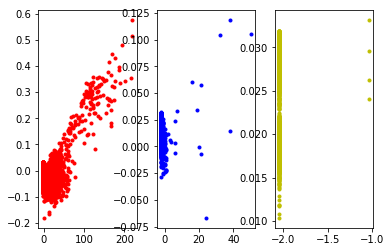

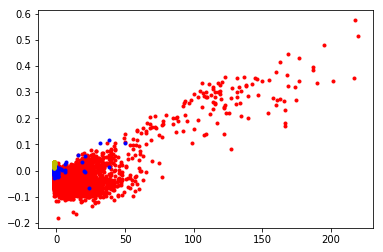

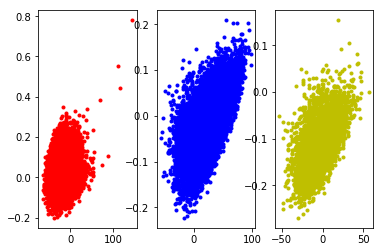

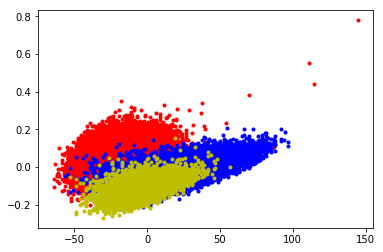

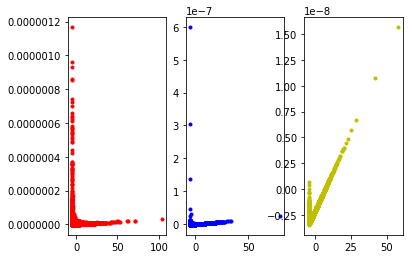

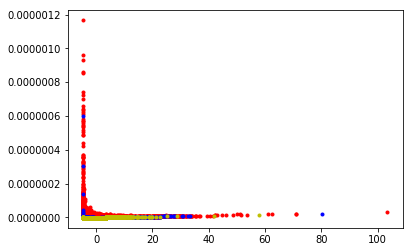

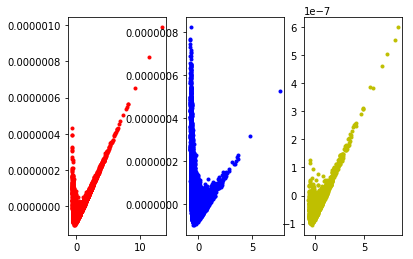

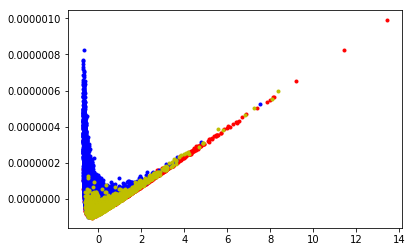

In [91]:
plot_PCA_clusters(x_train_emg_feat, y_train)
plot_PCA_clusters(x_train_eeg_1_feat, y_train)
plot_PCA_clusters(x_train_emg_feat_spec, y_train)
plot_PCA_clusters(x_train_eeg_1_feat_spec, y_train)


In [104]:
# VALIDTION of first sleep vs none sleep
# split_train_validation
X_train_fold_emg, y_train_fold, X_valid_fold_emg, y_valid_fold = split_train_validation(x_train_emg_feat, y_train)

# train scalers
scaler = StandardScaler().fit(x_train_emg_feat)

# get the training for the awake/sleep clf
awake_fold = X_train_fold_emg[y_train_fold == 1]
sleep_fold = X_train_fold_emg[y_train_fold != 1]
X_train_fold_awake_sleep = np.concatenate((awake_fold, sleep_fold))
y_train_fold_awake_sleep = np.concatenate((np.ones(awake_fold.shape[0], dtype=np.int32), np.zeros(sleep_fold.shape[0], dtype=np.int32)))

# get the validitation split
awake_fold = X_valid_fold_emg[y_valid_fold == 1]
sleep_fold = X_valid_fold_emg[y_valid_fold != 1]
X_valid_fold_awake_sleep = np.concatenate((awake_fold, sleep_fold))
y_valid_fold_awake_sleep = np.concatenate((np.ones(awake_fold.shape[0], dtype=np.int32), np.zeros(sleep_fold.shape[0], dtype=np.int32)))

# scale 
X_train_fold_awake_sleep = scaler.transform(X_train_fold_awake_sleep)
X_valid_fold_awake_sleep = scaler.transform(X_valid_fold_awake_sleep)

# fit classifier
rf_emg = RandomForestClassifier(n_estimators=2000, random_state=seed, n_jobs=-1, verbose=False)
rf_emg.fit(X_train_fold_awake_sleep, y_train_fold_awake_sleep)

# prediction
y_pred = rf_emg.predict(X_valid_fold_awake_sleep)

bmac_score = balanced_accuracy_score(y_valid_fold_awake_sleep, y_pred)
print(f"Validation of sleep vs awake balanced_accuracy_score: {bmac_score}")

Validation of sleep vs awake balanced_accuracy_score: 0.5271944806291311


In [18]:
# VALIDTION
# split_train_validation
X_train_fold_emg, y_train_fold, X_valid_fold_emg, y_valid_fold = split_train_validation(x_train_emg_feat, y_train)
X_train_fold_eeg, _, X_valid_fold_eeg, _ = split_train_validation(x_train_eeg_1_feat, y_train)

# train scalers
scaler = StandardScaler().fit(x_train_emg_feat)
scaler_eeg = StandardScaler().fit(x_train_eeg_1_feat)




# get the training for the awake/sleep clf
awake_fold = X_train_fold_emg[y_train_fold == 1]
sleep_fold = X_train_fold_emg[y_train_fold != 1]
X_train_fold_awake_sleep = np.concatenate((awake_fold, sleep_fold))
y_train_fold_awake_sleep = np.concatenate((np.ones(awake_fold.shape[0], dtype=np.int32), np.zeros(sleep_fold.shape[0], dtype=np.int32)))

# get the training for nrem and rem sleep
nrem_fold = X_train_fold_eeg[y_train_fold == 2]
rem_fold = X_train_fold_eeg[y_train_fold == 3]
X_train_fold_sleep_type = np.concatenate((nrem_fold, rem_fold))
y_train_sleep_type = np.concatenate((np.ones(nrem_fold.shape[0], dtype=np.int32) * 2, np.ones(rem_fold.shape[0], dtype=np.int32) * 3))

# scale 
X_train_fold_awake_sleep = scaler.transform(X_train_fold_awake_sleep)
X_train_fold_sleep_type = scaler_eeg.transform(X_train_fold_sleep_type)

# class weights
classes = np.array([2,3])
weights = compute_class_weight("balanced", classes, y_train_sleep_type)
cw = dict(zip(classes, weights))

# classifiers
rf_emg = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1, verbose=False)
rf_eeg = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1, class_weight=cw, verbose=False)

# fit classifier
rf_emg.fit(X_train_fold_awake_sleep, y_train_fold_awake_sleep)
rf_eeg.fit(X_train_fold_sleep_type, y_train_sleep_type)

# scale validation
X_valid_fold_emg = scaler.transform(X_valid_fold_emg)
X_valid_fold_eeg = scaler_eeg.transform(X_valid_fold_eeg)

y_pred = rf_emg.predict(X_valid_fold_emg)

# compute where y_pred is zero 0 => sleep
X_fold_valid_emg_sleep = X_valid_fold_eeg[y_pred == 0]
sleep_index = np.argwhere(y_pred == 0)

# predicted the type of sleep
y_sleep = rf_eeg.predict(X_fold_valid_emg_sleep)

# compute the final prediction vector
j = 0
for i in sleep_index:
    y_pred[i] = y_sleep[j]
    j +=1


bmac_score = balanced_accuracy_score(y_valid_fold, y_pred)
print(f"Valibalanced_accuracy_score: {bmac_score}")

Validation balanced_accuracy_score: 0.3739123914734674


In [123]:
# FINAL PREDICTION
scaler = StandardScaler().fit(x_train_emg_feat)
scaler_eeg = StandardScaler().fit(x_train_eeg_1_feat)

# class weights
classes = np.array([2,3])
weights = compute_class_weight("balanced", classes, y_train_eeg)
cw = dict(zip(classes, weights))

# classifiers
rf_emg = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1, verbose=False)
rf_eeg = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1, class_weight=cw, verbose=False)

# get the training for the awake/sleep clf
awake = x_train_emg_feat[y_train == 1]
sleep = x_train_emg_feat[y_train != 1]
X_train_awake_sleep = np.concatenate((awake, sleep))
y_train_awake_sleep = np.concatenate((np.ones(awake.shape[0], dtype=np.int32), np.zeros(sleep.shape[0], dtype=np.int32)))


# get the training for nrem and rem sleep
nrem = x_train_eeg_1_feat[y_train == 2]
rem = x_train_eeg_1_feat[y_train == 3]
X_train_sleep_type = np.concatenate((nrem, rem))
y_train_sleep_type = np.concatenate((np.ones(nrem.shape[0], dtype=np.int32) * 2, np.ones(rem.shape[0], dtype=np.int32) * 3))

# scale 
X_train_awake_sleep = scaler.transform(X_train_awake_sleep)
X_train_sleep_type = scaler_eeg.transform(X_train_sleep_type)
X_test_emg = scaler.transform(x_test_emg_feat)
X_test_eeg_1 = scaler_eeg.transform(x_test_eeg_1_feat)

# fit classifier
rf_emg.fit(X_train_awake_sleep, y_train_awake_sleep)
rf_eeg.fit(X_train_sleep_type, y_train_sleep_type)

# prediction
y_pred = rf_emg.predict(X_test_emg)

# compute where y_pred is zero 0 => sleep
X_test_eeg_1_sleep = X_test_eeg_1[y_pred == 0]
sleep_index = np.argwhere(y_pred == 0)

# predicted the type of sleep
y_sleep_type = rf_eeg.predict(X_test_eeg_1_sleep)

# compute the final prediction vector
j = 0
for i in sleep_index:
    y_pred[i] = y_sleep_type[j]
    j +=1

In [124]:
submission_name = "ax_multi_stage.csv"

print(f"Class 1: {np.sum(y_pred == 1)}")
print(f"Class 2: {np.sum(y_pred == 2)}")
print(f"Class 3: {np.sum(y_pred == 3)}")

y_pred_df = pd.DataFrame(y_pred)
y_pred_df = y_pred_df.assign(Id=list(range(y_pred.shape[0])))
y_pred_df.columns = ['y', 'Id']
display(y_pred_df)


submission_folder = os.path.join(dir_path,"submissions/")
csv_file = submission_folder + submission_name

with open(csv_file, 'w') as csv:
    y_pred_df.to_csv(csv,index = False)
"""
Class 1: 23933
Class 2: 18553
Class 3: 714
"""

Class 1: 23933
Class 2: 18553
Class 3: 714


,y,Id
0,1,0
1,1,1
2,1,2
3,1,3
4,1,4
5,1,5
6,1,6
7,1,7
8,1,8
9,1,9


'\nClass 1: 23933\nClass 2: 18553\nClass 3: 714\n'